In [64]:
import numpy as np
import h5py
from pylab import *
import matplotlib

import matplotlib.pyplot as plt
import scipy.interpolate as interp

from helper_functions import normalize_features, initialize_parameters, get_Yhat, get_accuracy_logistic

%matplotlib inline

### Logistic Cost Function (Unregularized) ###


$$J(W, X, Y) = - \frac{1}{m} \sum\limits_{k=1}^K\sum\limits_{i=1}^m Y_k^{(i)}log(h_{W}(x^{(i)})_k) + (1 - Y_k^{(i)} )log(1- h_W(x^{(i)})_k) $$

In [65]:
def compute_cost_logistic(Yhat, Y, derivative=False):
    assert (Yhat.shape == Y.shape)

    if derivative:
        return np.divide(1 - Y, 1 - Yhat) - np.divide(Y, Yhat)
    else:
        m = Y.shape[0]
        return (-1.0 / m) * np.sum(np.dot(Y.T, np.log(Yhat)) + np.dot((1-Y).T, np.log(1-Yhat)))

### Activation Functions ###

$$ sigmoid(Z) = \frac{1}{1 + e^{-Z}} $$
$$ tanh(Z) $$

In [66]:
def sigmoid(Z, derivative=False):
    if derivative:
        return np.multiply(sigmoid(Z), (1-sigmoid(Z)))
    else:
        return 1 / (1 + np.exp(-Z))


def tanh(Z, derivative=False):
    if derivative:
        return 1 - np.power(np.tanh(Z), 2)
    else:
        return np.tanh(Z)
    
    
def ReLU(Z, derivative=False):
    if derivative:
        return Z > 0
    else:
        return np.multiply(Z, (Z > 0))

In [67]:
def get_data_sets():
    test_path = 'datasets/cats/test_catvnoncat.h5'
    train_path = 'datasets/cats/train_catvnoncat.h5'

    train_dataset = h5py.File(train_path, "r")
    X_train = np.array(train_dataset["train_set_x"][:])
    Y_train = np.array(train_dataset["train_set_y"][:])
    mtrain = X_train.shape[0]
    X_train = X_train.reshape(mtrain, -1)
    Y_train = Y_train.reshape(mtrain, 1)

    test_dataset = h5py.File(test_path, "r")
    X_test = np.array(test_dataset["test_set_x"][:])
    Y_test = np.array(test_dataset["test_set_y"][:])
    mtest = X_test.shape[0]
    X_test = X_test.reshape(mtest, -1)
    Y_test = Y_test.reshape(mtest, 1)

    nx = X_train.shape[1]
    ny = Y_train.shape[1]

    return X_train, Y_train, mtrain, X_test, Y_test, mtest, nx, ny

In [68]:
def forwardpropagate(X, parameters, activation_functions):
    last_layer = len(activation_functions)

    def forwardpropagate_recurse(outputs, layer=1):
        prev_A = outputs["A" + str(layer - 1)]
        g = activation_functions["g" + str(layer)]
        W = parameters["W" + str(layer)]
        b = parameters["b" + str(layer)]

        Z = np.dot(W, prev_A) + b
        outputs["A" + str(layer)] = g(Z)
        outputs["Z" + str(layer)] = Z

        if layer != last_layer:
            return forwardpropagate_recurse(outputs, layer + 1)

        return outputs

    outputs = {"A0": X.T}
    return forwardpropagate_recurse(outputs)


def backpropagate(outputs, parameters, activation_functions, Y, cost_function, lambd = 0.0):
    m = Y.shape[0]
    last_layer = len(activation_functions)
    gradients = {}

    def backpropagate_recurse(layer=1):

        if layer != last_layer:
            this_dA = backpropagate_recurse(layer + 1)
        else:  # this is the last layer
            Yhat = outputs["A" + str(layer)].T
            this_dA = cost_function(Yhat, Y, derivative=True).T

        this_dg = activation_functions["g" + str(layer)]
        this_W = parameters["W" + str(layer)]
        this_Z = outputs["Z" + str(layer)]
        prev_A = outputs["A" + str(layer - 1)]

        this_dZ = np.multiply(this_dA, this_dg(this_Z, derivative=True))

        gradients["dW" + str(layer)] = ( (1.0 / m) * np.dot(this_dZ, prev_A.T) ) + ( (lambd / m) * this_W )
        gradients["db" + str(layer)] = (1.0 / m) * np.sum(this_dZ, axis=1, keepdims=True)

        return np.dot(this_W.T, this_dZ)  # return prev_dA

    backpropagate_recurse()
    return gradients


In [69]:
def model_nn(X_tr, Y_tr, X_cv, Y_cv, 
             learning_rate, lambd,
             layer_dims, activation_functions, cost_function, 
             min_iterations, max_iterations, step_size):
    
    i_vals, cv_cost_vals, tr_cost_vals, accuracy_vals = ( [] for i in range(4) )
    parameters = initialize_parameters(layer_dims)
    num_layers = len(activation_functions)

    for i in range(min_iterations, max_iterations):
        outputs = forwardpropagate(X_tr, parameters, activation_functions)
        gradients = backpropagate(outputs, parameters, activation_functions, Y_tr, cost_function, lambd)
        for layer in range(1, num_layers+1):
            parameters["W" + str(layer)] -= learning_rate * gradients["dW" + str(layer)]
            parameters["b" + str(layer)] -= learning_rate * gradients["db" + str(layer)]
            
        if i % step_size == 0:
            Yhat_tr = get_Yhat(X_tr, parameters, activation_functions)
            Yhat_cv = get_Yhat(X_cv, parameters, activation_functions)
            cost_tr = compute_cost_logistic(Yhat_tr, Y_tr)
            cost_cv = compute_cost_logistic(Yhat_cv, Y_cv)
            accuracy = get_accuracy_logistic(Yhat_cv, Y_cv)
            
            i_vals.append(i)
            cv_cost_vals.append(cost_cv)
            tr_cost_vals.append(cost_tr)
            accuracy_vals.append(accuracy)
            
    data = {"i_vals" : i_vals,
            "cv_cost_vals" : cv_cost_vals,
            "tr_cost_vals" : tr_cost_vals,
            "accuracy_vals" : accuracy_vals}
    
    return parameters, data

(209, 12288)
(209, 1)


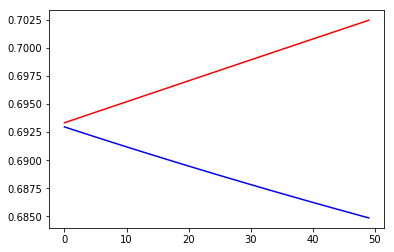

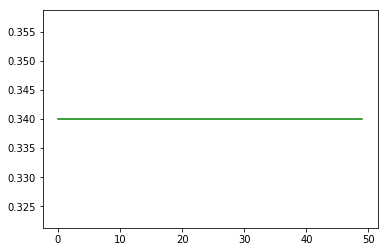

In [75]:
# NN Settings
learning_rate = 0.0075
lambd = 0.05


# NN Architecture
X_tr, Y_tr, m_tr, X_cv, Y_cv, m_cv, nx, ny = get_data_sets()

activation_functions = {"g1": ReLU,
                        "g2": ReLU,
                        "g3": ReLU,
                        "g4": sigmoid}

layer_dims = [nx, 20, 7, 5, ny]

assert (len(activation_functions) == (len(layer_dims) - 1))


# Iteration Settings
min_iterations = 0
max_iterations = 50
step_size = 1


# Pre-process Data
X_tr = X_tr / 255
X_cv = X_cv / 255
print(X_tr.shape)
print(Y_tr.shape)

# Run  
parameters, data = model_nn(X_tr, Y_tr, X_cv, Y_cv, 
                            learning_rate, lambd,
                            layer_dims, activation_functions, compute_cost_logistic, 
                            min_iterations, max_iterations, step_size)

# Unpack Data
i_vals = data["i_vals"]
cv_cost_vals = data["cv_cost_vals"]
tr_cost_vals = data["tr_cost_vals"]
accuracy_vals = data["accuracy_vals"]


plt.plot(i_vals, cv_cost_vals, 'r')
plt.plot(i_vals, tr_cost_vals, 'b')
plt.show()

plt.plot(i_vals, accuracy_vals, 'g')
plt.show()